# Classifying urban sounds using deep learning models.
## Data preprocessing
### Properties to be normalized:
During exploration it was found that the following properties needed normalization:
 - Audio channel number.
 - Sample Rate
 - Bit Depth
 
 Much of the preprocessing can be done via Librosa's load() function. The output of this function will be compared against the default parameters of scipy's wavefile library which will output original properties.

Original sample rate: 44100
Resampled rate: 22050
Original file min/max range:  -5462  to  5355
Resampled file min/max range:  -0.1260349  to  0.114439055



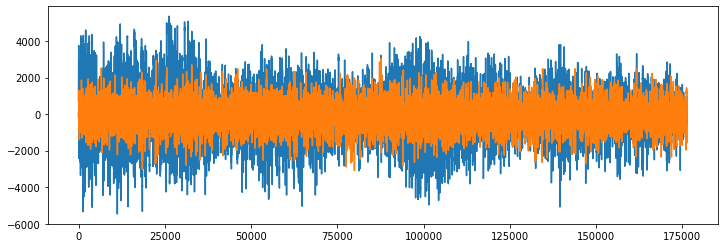

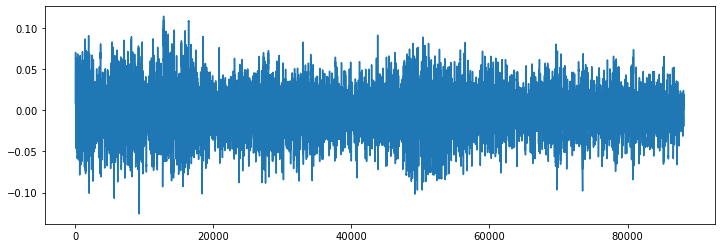

In [10]:
import librosa
from scipy.io import wavfile as wav
import numpy as np
import matplotlib.pyplot as plt


def preprocess_file(file):
    #sample rate conversion
    libro_audio, libro_sr = librosa.load(file)
    scipy_sr,scipy_audio = wav.read(file)
    print('Original sample rate:',scipy_sr)
    print('Resampled rate:',libro_sr)
    
    #bit depth converstion
    print('Original file min/max range: ',np.min(scipy_audio),' to ',np.max(scipy_audio))
    print('Resampled file min/max range: ',np.min(libro_audio),' to ',np.max(libro_audio))
    
    #Combining audio channels
    plt.figure(figsize=(12, 4))
    plt.plot(scipy_audio)
    print('')
    plt.figure(figsize=(12, 4))
    plt.plot(libro_audio)
    plt.show()
    
    return libro_audio,libro_sr,scipy_audio,scipy_sr
    
libro_audio,libro_sr,scipy_audio,scipy_sr = preprocess_file('data/UrbanSound8K/audio/fold6/184805-0-0-47.wav')

## Feature Extraction
As mentioned in the proposal, we will extract [Mel-Frequency Cepstral Coefficients (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) from the the audio samples. 

The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

### Extracting a MFCC

In [2]:
mfccs = librosa.feature.mfcc(y=libro_audio, sr=libro_sr, n_mfcc=40)
#mfccs = librosa.amplitude_to_db(mfccs)
print(mfccs.shape)

(40, 173)


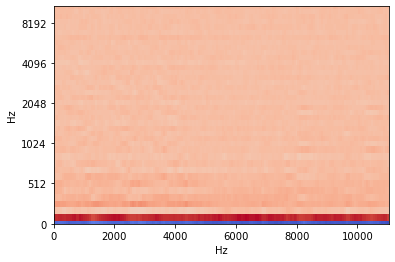

In [3]:
import librosa.display
librosa.display.specshow(mfccs, sr=libro_sr, x_axis='hz',y_axis='mel')

### Loading audio and metadata.
The audio files and their corresponding metadata are used to create a dataframe that stores preprocessed audio, corresponding classes and an ordered array of classes such that the position of a class is the same as its class ID.

In [4]:
import librosa
import sys
from random import randrange
import os
#from numba import njit

#@njit
#def add_noise(data,noise_factor=0.1):
#    for point in range(len(data)):
#        data[point] = (data[point]+(randrange(0,int(255-data[point]))*noise_factor))
#    return data

def extract_mfcc(index,row):
    file = os.path.join(os.path.abspath('data/urbansound8k/audio'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    label =  row['class']
    max_padding = 175
    try:
        audio,sample_rate = librosa.load(file,res_type='kaiser_fast')
        #audio = add_noise(audio,noise_factor=0.2)  
            
    except Exception as e:
        print('Error on line {}'.format(sys.exc_info()[-1].tb_lineno), type(e).__name__, e)
        return None
    
    mfccs = librosa.feature.mfcc(y=audio, n_mfcc=40)
    pad_width = max_padding - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    return [mfccs,label]

In [5]:
%%time

import pandas as pd
import concurrent.futures
from tqdm.notebook import tqdm
from random import seed,randint

#n_samples = 20000

seed(2836)
metadata = pd.read_csv('data/urbansound8k/metadata/UrbanSound8k.csv')
#metadata_extended = pd.DataFrame([metadata.iloc[randint(0,len(metadata.index)-1)] for i in range(n_samples)],columns=metadata.columns)
data =[]

#multithreaded run of the function
with concurrent.futures.ThreadPoolExecutor() as exe:
    #lambda function was used to pass multiple args to the function
    data = list(tqdm(exe.map(lambda p:extract_mfcc(*p),metadata.iterrows()),total=len(metadata.index),leave=None))


Wall time: 3min 5s


In [6]:
#Slicing metadata and ordering the slice according to class IDs
classes_unique = metadata[['classID','class']].drop_duplicates('classID')
classes_unique.sort_values(by='classID',inplace=True)
classes = np.array(classes_unique['class'])
classes

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [7]:
#Putting the data into pandas a dataframe
dataframe = pd.DataFrame(data,columns=['features', 'class'])

### Convert data and labels
Categorical text data in the labels is encoded into numerical format because most machine learning models only work on numerical data. The module used here is the `sklearn.preprocessing.LabelEncoder`. The labels are converted to categorical using `keras.utils.to_categorical`. This ensures that the model does not find any mathematical features in the label.

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X = np.array(dataframe['features'].tolist())
y = np.array(dataframe['class'].tolist())

encoder = LabelEncoder()
cat_y = to_categorical(encoder.fit_transform(y))

Using TensorFlow backend.


#### Saving dataset for later use

In [9]:
%%time

out_path = 'data/dataset.npz'
try:
    np.savez(out_path,features=X,labels=cat_y,classes=classes)
except Exception as e:
    print(e)
else:
    print('Done!')

Done!
Wall time: 584 ms
